# Counterfactual Transportability - Advanced Features

This notebook is a demonstration of some of the debugging features in the $Y_0$ implementation of algorithms from Correa, Lee, and Bareinboim's 2022 paper, [Counterfactual Transportability: A Formal Approach](https://proceedings.mlr.press/v162/correa22a/correa22a.pdf).

In [23]:
import logging

from y0.algorithm.counterfactual_transport.api import (
    CFTDomain,
    conditional_cft,
    unconditional_cft,
)
from y0.algorithm.transport import transport_variable
from y0.dsl import (
    TARGET_DOMAIN,
    X1,
    Pi1,
    R,
    Variable,
    W,
    X,
    Y,
    Z,
)
from y0.graph import NxMixedGraph

## Insight into how the algorithms work

We can run the previous two models with the debugger enabled for more insight into what's going on under the hood. Let's load up our example from the basic Counterfactual Transportability notebook:

In [24]:
Vaccinated = Variable("V")
Antibody = Variable("A")
Infected = Variable("I")

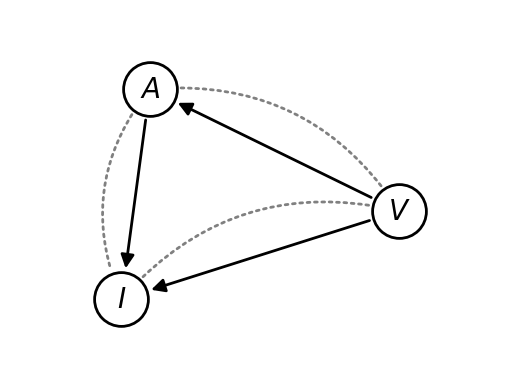

In [25]:
# This graph represents the target domain, the United States.
USA = Variable("USA")

observational_study_in_usa_graph = NxMixedGraph.from_edges(
    directed=[
        (Vaccinated, Antibody),
        (Antibody, Infected),
        (Vaccinated, Infected),
    ],
    undirected=[(Vaccinated, Antibody), (Vaccinated, Infected), (Antibody, Infected)],
)
observational_study_in_usa_graph.draw()

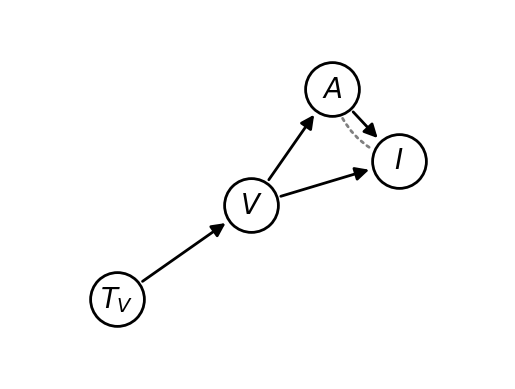

In [26]:
Australia = Variable("AUS")

vaccine_efficacy_in_australia_graph = NxMixedGraph.from_edges(
    directed=[
        (Vaccinated, Antibody),
        (Vaccinated, Infected),
        (Antibody, Infected),
        (transport_variable(Vaccinated), Vaccinated),
    ],
    undirected=[(Antibody, Infected)],
)
vaccine_efficacy_in_australia_graph.draw()

In [27]:
domains = [
    CFTDomain(
        population=Australia,
        graph=vaccine_efficacy_in_australia_graph,
        policy_variables={Vaccinated},
    ),
    CFTDomain(
        population=USA,
        graph=observational_study_in_usa_graph,
    ),
]

# Unconditional model

In [28]:
event = [(+Infected @ -Vaccinated)]
unconditional_cft_result = unconditional_cft(
    event=event, target_domain_graph=observational_study_in_usa_graph, domains=domains
)
unconditional_cft_result.expression

DEBUG:y0.algorithm.counterfactual_transport.api:In unconditional_cft: domain_data = [({V}, PP[AUS](A, I, V)), (set(), PP[USA](A, I, V))]
DEBUG:y0.algorithm.counterfactual_transport.api:In simplify: event = [(I @ -V, +I)]
DEBUG:y0.algorithm.counterfactual_transport.api:In simplify: minimized_event = [(I @ -V, +I)]
DEBUG:y0.algorithm.counterfactual_transport.api:In simplify after part 1 of line 3: minimized_nonreflexive_variable_to_value_mappings = {I @ -V: {+I}}
DEBUG:y0.algorithm.counterfactual_transport.api:                                    minimized_reflexive_variable_to_value_mappings = {}
DEBUG:y0.algorithm.counterfactual_transport.api:In simplify after line 2: minimized_nonreflexive_variable_to_value_mappings = {I @ -V: {+I}}
DEBUG:y0.algorithm.counterfactual_transport.api:                                    minimized_reflexive_variable_to_value_mappings = {}
DEBUG:y0.algorithm.counterfactual_transport.api:In simplify after part 2 of line 3: minimized_reflexive_variable_to_value

Sum[A](PP[AUS](A | V) * PP[AUS](I | A, V))

We'd like to take a look at why, for our unconditional counterfactual transportability example, we transport information from Australia. Let's enable debugging, and fit the unconditional model. 

In [29]:
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.DEBUG)

By displaying the domains, we remind ourselves that it's an array with the first element representing Australia and the second, the United States.

In [30]:
domains

[CFTDomain(graph=NxMixedGraph(directed=<networkx.classes.digraph.DiGraph object at 0x71d06f5d1c90>, undirected=<networkx.classes.graph.Graph object at 0x71d06ec1ed50>), population=PP[AUS](A, I, V), policy_variables={V}, ordering=None),
 CFTDomain(graph=NxMixedGraph(directed=<networkx.classes.digraph.DiGraph object at 0x71d071652290>, undirected=<networkx.classes.graph.Graph object at 0x71d06f5d2150>), population=PP[USA](A, I, V), policy_variables=set(), ordering=None)]

Let's fit the model.

In [31]:
event = [(+Infected @ -Vaccinated)]
unconditional_cft_result = unconditional_cft(
    event=event, target_domain_graph=observational_study_in_usa_graph, domains=domains
)
unconditional_cft_result.expression

DEBUG:y0.algorithm.counterfactual_transport.api:In unconditional_cft: domain_data = [({V}, PP[AUS](A, I, V)), (set(), PP[USA](A, I, V))]
DEBUG:y0.algorithm.counterfactual_transport.api:In simplify: event = [(I @ -V, +I)]
DEBUG:y0.algorithm.counterfactual_transport.api:In simplify: minimized_event = [(I @ -V, +I)]
DEBUG:y0.algorithm.counterfactual_transport.api:In simplify after part 1 of line 3: minimized_nonreflexive_variable_to_value_mappings = {I @ -V: {+I}}
DEBUG:y0.algorithm.counterfactual_transport.api:                                    minimized_reflexive_variable_to_value_mappings = {}
DEBUG:y0.algorithm.counterfactual_transport.api:In simplify after line 2: minimized_nonreflexive_variable_to_value_mappings = {I @ -V: {+I}}
DEBUG:y0.algorithm.counterfactual_transport.api:                                    minimized_reflexive_variable_to_value_mappings = {}
DEBUG:y0.algorithm.counterfactual_transport.api:In simplify after part 2 of line 3: minimized_reflexive_variable_to_value

Sum[A](PP[AUS](A | V) * PP[AUS](I | A, V))

For the unconditional model, we look at Australia first. The unconditional counterfactual transportability algorithm first computes an _ancestral set_: the counterfactual ancestors of the outcome variables in the target domain graph. (Ancestors of a counterfactual variable as defined in [Counterfactual Transportability: A Formal Approach](https://proceedings.mlr.press/v162/correa22a/correa22a.pdf) are different than mere ancestors of a variable in a graph, and are not immediately obvious from looking at the graph.) Next the algorithm groups the variables in this set into _counterfactual factors_, that is, groups of variables connected by bi-directed edges in the target domain graph. Then, for each (source) domain and for each counterfactual factor, we conduct a check to see whether any vertex in the factor for the domain is in the set of policy variables for that domain, or is a transportability node. If there exists such a vertex (i.e., the check fails), we cannot transport that counterfactual factor from that domain, and move on to the next available domain. If the check passes, then we run the Tian-Pearl Identification algorithm to see if the counterfactual factor is identified and if it is, we conclude that that counterfactual factor is transportable from the associated source domain to the target domain. If the check fails or the Tian-Pearl Identification algorithm shows that the counterfactual factor is not identified for that domain, then we keep trying additional domains for that counterfactual factor until we run out of domains or we find a domain for which the factor is transportable. In this manner we loop through all the counterfactual factors and either return `None` if any counterfactual factor cannot be transported for all source domains, or else combine the probabilities associated with each transported counterfactual factor as specified by the algorithm and return the result. In this case, we have a single counterfactual factor in the target domain that is identified for Australia, the first domain in the array passed to it; we thus return the associated probability. [TODO: numbered list]

# Conditional model

In the basic example we saw that a conditional counterfactual transportability model is identified for the United States, despite that being an observational graph with many confounding variables present. Let's run the model with the debugger and see why we are able to fit the conditional model.

In [19]:
conditional_cft_result = conditional_cft(
    outcomes=[+Infected @ +Vaccinated],
    conditions=[+Vaccinated],
    target_domain_graph=observational_study_in_usa_graph,
    domains=domains,
)

conditional_cft_result.expression

DEBUG:/home/allanon/Documents/Causality/y0/y0/src/y0/algorithm/counterfactual_transport/ancestor_utils.py:In _get_ancestral_components: ancestral_sets = {frozenset({A @ +V, I @ +V}), frozenset({V})}
DEBUG:/home/allanon/Documents/Causality/y0/y0/src/y0/algorithm/counterfactual_transport/ancestor_utils.py:In _get_ancestral_components: computed these ancestral components: frozenset({frozenset({A @ +V, V, I @ +V})})
DEBUG:y0.algorithm.counterfactual_transport.api:In _transport_conditional_counterfactual_query_line_2: ancestral_components = frozenset({frozenset({A @ +V, V, I @ +V})})
DEBUG:y0.algorithm.counterfactual_transport.api:In _transport_conditional_counterfactual_query_line_2: outcome_variables = {I @ +V}
DEBUG:y0.algorithm.counterfactual_transport.api:In _transport_conditional_counterfactual_query_line_2: outcome_variable_to_value_mappings = {I @ +V: {+I}}
DEBUG:y0.algorithm.counterfactual_transport.api:In _transport_conditional_counterfactual_query_line_2: conditioned_variable_to_

((Sum[A](PP[USA](A | V) * PP[USA](I | A, V) * PP[USA](V)) / Sum[A, I](PP[USA](A | V) * PP[USA](I | A, V) * PP[USA](V))))

The conditional counterfactual transportability algorithm calls the unconditional algorithm, but first computes _ancestral components_ for the target domain graph, that is, groups of ancestral sets that are unioned together in cases where two sets are not disjoint or members of the sets are connected by bidirected edges. The practical effect of this step is to potentially expand the query passed to the unconditional transportability algorithm to include more counterfactual variables in the unconditional query than existed in the conditional query. Sometimes, that may cause a query to be identified. In the present case, the previous unconditional query boiled down to running the Tian-Pearl identification algorithm on a counterfactual factor containing the vertices Antibody and Infected; for the conditional query, that counterfactual factor expands to include Vaccinated. The practical effect is that because Vaccinated is both a transportability node and a policy variable for Australia, Australia is no longer transportable -- but the USA domain becomes identifiable anyway.

# Detecting Inconsistent Counterfactual Factors

In some cases, a query may fail because counterfactual factors are _inconsistent_ -- that is, if the query results in a variable in a counterfactual factor being simultaneously set to more than one value, or if one of the parents of a variable in a counterfactual factor is simultaneously set to more than one value. In such cases, the algorithm returns `None`, and running the query in debug mode yields insight into which counterfactual factor (or factors) are inconsistent and why.  

In [20]:
# Revised version of conditional_cft(), after we include conditioned variable values that are part of
# outcome ancestral components in the call to transport_unconditional_counterfactual_query()
conditional_cft_result = conditional_cft(
    outcomes=[+Infected @ -Vaccinated],
    conditions=[+Vaccinated],
    target_domain_graph=observational_study_in_usa_graph,
    domains=domains,
)

conditional_cft_result is None

DEBUG:/home/allanon/Documents/Causality/y0/y0/src/y0/algorithm/counterfactual_transport/ancestor_utils.py:In _get_ancestral_components: ancestral_sets = {frozenset({A @ -V, I @ -V}), frozenset({V})}
DEBUG:/home/allanon/Documents/Causality/y0/y0/src/y0/algorithm/counterfactual_transport/ancestor_utils.py:In _get_ancestral_components: computed these ancestral components: frozenset({frozenset({A @ -V, I @ -V, V})})
DEBUG:y0.algorithm.counterfactual_transport.api:In _transport_conditional_counterfactual_query_line_2: ancestral_components = frozenset({frozenset({A @ -V, I @ -V, V})})
DEBUG:y0.algorithm.counterfactual_transport.api:In _transport_conditional_counterfactual_query_line_2: outcome_variables = {I @ -V}
DEBUG:y0.algorithm.counterfactual_transport.api:In _transport_conditional_counterfactual_query_line_2: outcome_variable_to_value_mappings = {I @ -V: {+I}}
DEBUG:y0.algorithm.counterfactual_transport.api:In _transport_conditional_counterfactual_query_line_2: conditioned_variable_to_

True

In the above case, we ask for the probability that an individual is infected given they are vaccinated, in a world in which we make them not be vaccinated. The query is inconsistent, and it returns FAIL. We see that the consistency check finds two values for the _vaccinated_ vertex _V_.

# Debugging Misconfigured Queries

$Y_0$ has a robust interface for detecting misconfigured queries. Here is an example where the conditional algorithm is run when there are no conditioned variables, and the user is prompted to run the unconditional algorithm instead:

In [21]:
conditional_cft_result = conditional_cft(
    outcomes=[+Infected @ -Vaccinated],
    conditions=[],
    target_domain_graph=observational_study_in_usa_graph,
    domains=domains,
)

conditional_cft_result.expression

ValueError: In _validate_transport_conditional_counterfactual_query_input: empty list for the conditions. Check your inputs or consider directly calling transport_unconditional_counterfactual_query().

## User interface demonstration

The following exercise is from a tutorial at Pacific Northwest National Laboratory that demonstrates that detailed validation of user inputs makes using the software easy. We've deliberately included some typos in the problem solution and show the software catching them. Feel free to experiment with the input parameters and generate other errors!

1. Construct a graph with the following edges:
   ```
   X1 -> Z,
   R -> Z,
   Z -> W,
   W -> Y,
   W <-> Z	
   ```
2. Consider you have available observational data from the target domain, and an experiment from Domain 1 in which $W$ is fixed to be only a function of $Z$ (breaking the bidirected edge between $W$ and $Z$), and $R$ is drawn from a different population than in the target domain.
3. Estimate $P(Y_{X1},W_{R}|X1)$ with the values ${-Y,-W,-X}$ respectively.

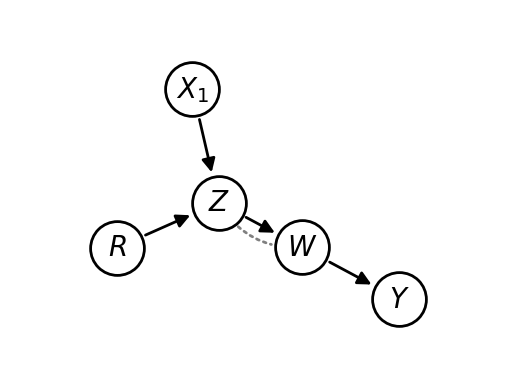

In [40]:
example_3_target_domain_graph = NxMixedGraph.from_edges(
    directed=[
        (X1, Z),
        (R, Z),
        (Z, W),
        (W, Y),
    ],
    undirected=[(Z, W)],
)
example_3_target_domain_graph.draw()

In [41]:
example_3_break_w_graph = NxMixedGraph.from_edges(
    directed=[
        (X1, Z),
        (R, Z),
        (Z, W),
        (W, Y),
        (transport_variable(R), R),
    ],
)
# example_3_break_w_graph.draw()

In [42]:
example_3_outcomes = [-Y @ -X1, -W @ -R]
example_3_conditions = [-X]  ## NOTE: Should be X1

example_3_target_domain_graph_topo = list(example_3_target_domain_graph.topological_sort())
example_3_break_w_graph_topo = list(example_3_break_w_graph.topological_sort())
example_3_domains = [
    CFTDomain(
        population=Pi1,
        graph=example_3_break_w_graph,
        ordering=example_3_break_w_graph_topo,
        policy_variables={W},
    ),
    CFTDomain(
        population=TARGET_DOMAIN,
        graph=example_3_target_domain_graph,
        # This is an intentionally incorrect topological ordering. To fix, do so manually or comment out the line entirely.
        ordering=[W, X1, R, Z, Y],
    ),
]
try:
    result = conditional_cft(
        outcomes=example_3_outcomes,
        conditions=example_3_conditions,
        target_domain_graph=example_3_target_domain_graph,
        domains=example_3_domains,
    )
    result.display()
except ValueError as e:
    print("error", e)

error In _validate_transport_conditional_counterfactual_query_input: one of the input conditioned variables is not in the target domain graph. Check your inputs. 
